In [1]:
# 1-2でargsで入れてたとこを手動
ds = "c100"
k = 0
take_abs = True
take_covavg = False

In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from utils.constant import ViTExperiment

# VScoreの類似度行列

In [5]:
def load_vscores_for_similarity(vscore_dir, cor_mis, end_li=12, num_labels=100, abs=True, covavg=False, split="repair"):
    vscores = []
    valid_labels = []

    for label_id in range(num_labels):
        prefix = ("vscore_abs" if abs else "vscore") + ("_covavg" if covavg else "")
        save_name = f"{prefix}_l1tol{end_li}_label_{label_id}_ori_{split}_{cor_mis}.npy"
        vscore_save_path = os.path.join(vscore_dir, save_name)
        if not os.path.exists(vscore_save_path):
            # print(f"[Warning] Missing file for label {label_id}: {vscore_save_path}")
            continue
        v = np.load(vscore_save_path)  # (12, 3072)
        if np.any(np.isnan(v)):
            print(f"[Warning] NaN values found in vscore for label {label_id}: {vscore_save_path}")
            continue
        vscores.append(v[-1])  # 1D (3072,)
        valid_labels.append(label_id)

    return np.array(vscores), valid_labels  # shape: (num_valid_labels, 3072)

def plot_similarity_heatmap(vscore_dir, cor_mis):
    vscores, label_ids = load_vscores_for_similarity(vscore_dir, cor_mis)
    similarity_matrix = cosine_similarity(vscores)  # (N, N)
    
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(similarity_matrix, xticklabels=label_ids, yticklabels=label_ids, cmap="viridis", square=True, vmin=0, vmax=1)
    plt.title(f"Cosine Similarity of VScores (layer 12) [{cor_mis}]")
    plt.xlabel("Label ID")
    plt.ylabel("Label ID")
    plt.tight_layout()
    plt.show()
    return similarity_matrix, label_ids

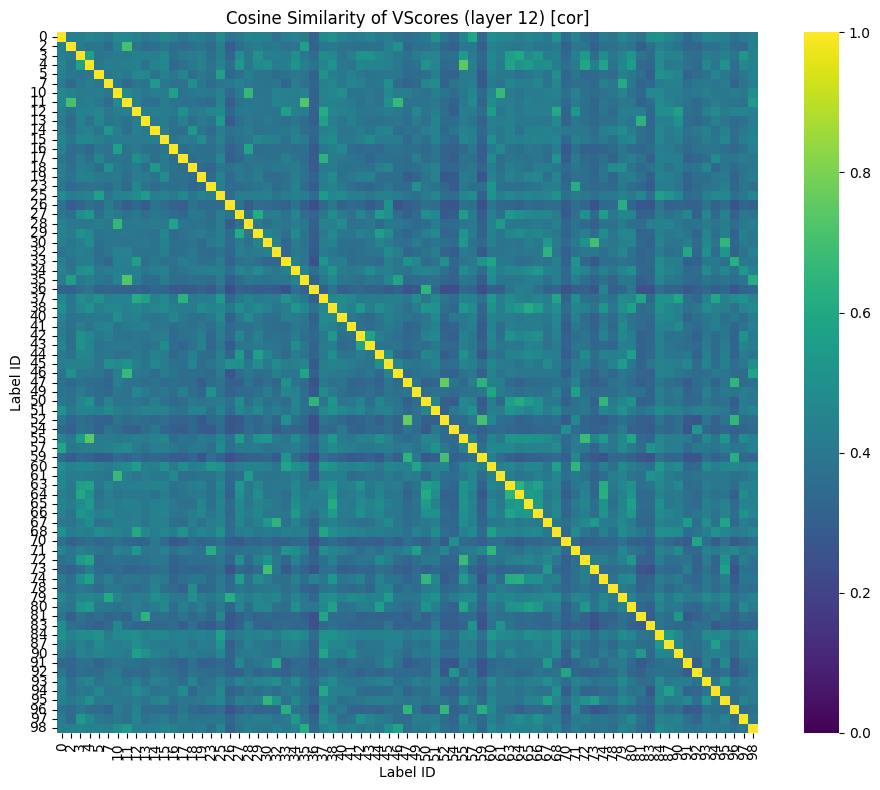

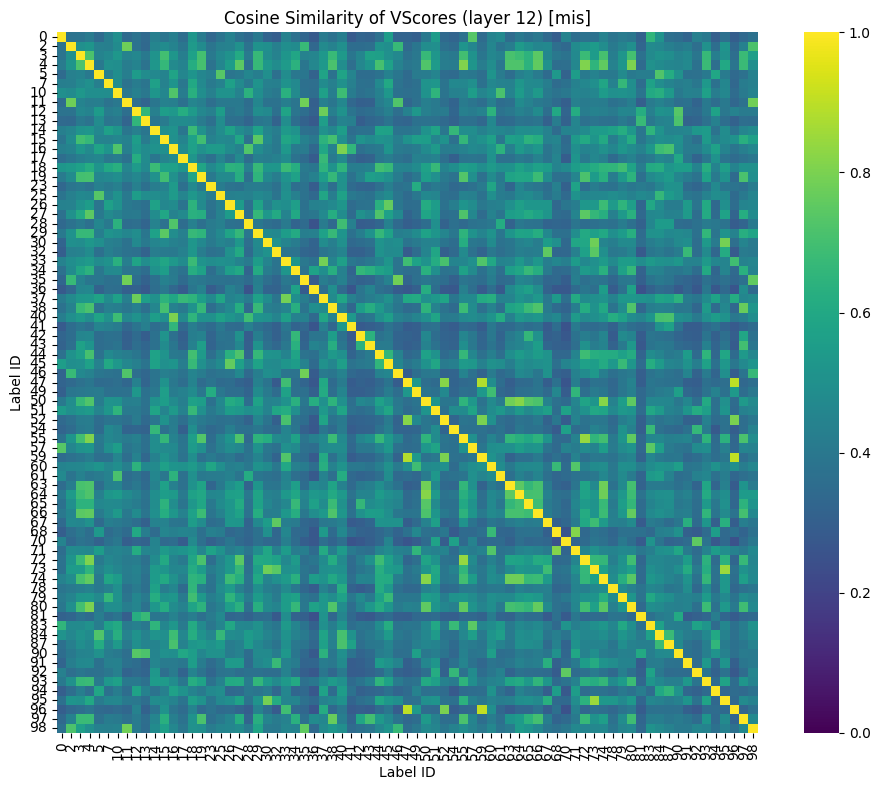

In [6]:
# 使用例
vscore_dir = os.path.join(getattr(ViTExperiment, ds).OUTPUT_DIR.format(k=k), "vscores_subsampled")
cor_sim, cor_label_ids = plot_similarity_heatmap(vscore_dir, cor_mis="cor")
mis_sim, mis_label_ids = plot_similarity_heatmap(vscore_dir, cor_mis="mis")

In [7]:
def get_top_k_similar_pairs(similarity_matrix, label_ids, id2label, top_k=30):
    pairs = []
    for i in range(len(label_ids)):
        for j in range(i + 1, len(label_ids)):  # 上三角のみ
            sim = similarity_matrix[i, j]
            pairs.append((i, j, sim))

    pairs = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"Top {top_k} most similar label pairs (off-diagonal):")
    for i, j, sim in pairs[:top_k]:
        lid_i = label_ids[i]
        lid_j = label_ids[j]
        print(f"({lid_i:2d}, {lid_j:2d}) : {id2label[lid_i]:15s} ↔ {id2label[lid_j]:15s} | similarity = {sim:.4f}")


id2label = {
    0: "apple",
    1: "aquarium_fish",
    2: "baby",
    3: "bear",
    4: "beaver",
    5: "bed",
    6: "bee",
    7: "beetle",
    8: "bicycle",
    9: "bottle",
    10: "bowl",
    11: "boy",
    12: "bridge",
    13: "bus",
    14: "butterfly",
    15: "camel",
    16: "can",
    17: "castle",
    18: "caterpillar",
    19: "cattle",
    20: "chair",
    21: "chimpanzee",
    22: "clock",
    23: "cloud",
    24: "cockroach",
    25: "couch",
    26: "cra",
    27: "crocodile",
    28: "cup",
    29: "dinosaur",
    30: "dolphin",
    31: "elephant",
    32: "flatfish",
    33: "forest",
    34: "fox",
    35: "girl",
    36: "hamster",
    37: "house",
    38: "kangaroo",
    39: "keyboard",
    40: "lamp",
    41: "lawn_mower",
    42: "leopard",
    43: "lion",
    44: "lizard",
    45: "lobster",
    46: "man",
    47: "maple_tree",
    48: "motorcycle",
    49: "mountain",
    50: "mouse",
    51: "mushroom",
    52: "oak_tree",
    53: "orange",
    54: "orchid",
    55: "otter",
    56: "palm_tree",
    57: "pear",
    58: "pickup_truck",
    59: "pine_tree",
    60: "plain",
    61: "plate",
    62: "poppy",
    63: "porcupine",
    64: "possum",
    65: "rabbit",
    66: "raccoon",
    67: "ray",
    68: "road",
    69: "rocket",
    70: "rose",
    71: "sea",
    72: "seal",
    73: "shark",
    74: "shrew",
    75: "skunk",
    76: "skyscraper",
    77: "snail",
    78: "snake",
    79: "spider",
    80: "squirrel",
    81: "streetcar",
    82: "sunflower",
    83: "sweet_pepper",
    84: "table",
    85: "tank",
    86: "telephone",
    87: "television",
    88: "tiger",
    89: "tractor",
    90: "train",
    91: "trout",
    92: "tulip",
    93: "turtle",
    94: "wardrobe",
    95: "whale",
    96: "willow_tree",
    97: "wolf",
    98: "woman",
    99: "worm"
}


In [8]:
get_top_k_similar_pairs(cor_sim, cor_label_ids, id2label, top_k=30)

Top 30 most similar label pairs (off-diagonal):
(47, 52) : maple_tree      ↔ oak_tree        | similarity = 0.7611
( 4, 55) : beaver          ↔ otter           | similarity = 0.7472
(11, 35) : boy             ↔ girl            | similarity = 0.7274
( 2, 11) : baby            ↔ boy             | similarity = 0.7041
(52, 59) : oak_tree        ↔ pine_tree       | similarity = 0.7025
(30, 73) : dolphin         ↔ shark           | similarity = 0.6964
(55, 72) : otter           ↔ seal            | similarity = 0.6768
(11, 46) : boy             ↔ man             | similarity = 0.6744
(10, 61) : bowl            ↔ plate           | similarity = 0.6689
(10, 28) : bowl            ↔ cup             | similarity = 0.6668
(52, 96) : oak_tree        ↔ willow_tree     | similarity = 0.6632
(50, 74) : mouse           ↔ shrew           | similarity = 0.6595
(60, 71) : plain           ↔ sea             | similarity = 0.6548
(47, 96) : maple_tree      ↔ willow_tree     | similarity = 0.6540
(30, 95) : dol

In [9]:
get_top_k_similar_pairs(mis_sim, mis_label_ids, id2label, top_k=30)

Top 30 most similar label pairs (off-diagonal):
(59, 96) : pine_tree       ↔ willow_tree     | similarity = 0.9098
(47, 96) : maple_tree      ↔ willow_tree     | similarity = 0.8998
(47, 59) : maple_tree      ↔ pine_tree       | similarity = 0.8856
(73, 95) : shark           ↔ whale           | similarity = 0.8500
(55, 72) : otter           ↔ seal            | similarity = 0.8417
(50, 64) : mouse           ↔ possum          | similarity = 0.8192
(47, 52) : maple_tree      ↔ oak_tree        | similarity = 0.8185
(50, 74) : mouse           ↔ shrew           | similarity = 0.8169
(68, 71) : road            ↔ sea             | similarity = 0.8132
( 4, 55) : beaver          ↔ otter           | similarity = 0.8111
( 4, 72) : beaver          ↔ seal            | similarity = 0.8084
( 4, 80) : beaver          ↔ squirrel        | similarity = 0.8042
(16, 40) : can             ↔ lamp            | similarity = 0.8031
(52, 59) : oak_tree        ↔ pine_tree       | similarity = 0.7992
(52, 96) : oak

# VScoreをt-SNEで2次元に落とす

ラベルごと, cor/misで合計 len(cor_label_ids) + len(mis_label_ids) 個のデータ点ができる．

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

def plot_tsne_cor_mis_vscores(vscore_dir, id2label, perplexity=30, random_state=42):
    # 1. load vscores
    v_cor, labels_cor = load_vscores_for_similarity(vscore_dir, "cor")
    v_mis, labels_mis = load_vscores_for_similarity(vscore_dir, "mis")

    cor_dict = {lid: v for lid, v in zip(labels_cor, v_cor)}
    mis_dict = {lid: v for lid, v in zip(labels_mis, v_mis)}

    # 2. concatenate vectors and metadata
    all_vecs, all_labels, all_flags = [], [], []

    for lid, vec in cor_dict.items():
        all_vecs.append(vec)
        all_labels.append(lid)
        all_flags.append("cor")

    for lid, vec in mis_dict.items():
        all_vecs.append(vec)
        all_labels.append(lid)
        all_flags.append("mis")
        
    # 全ラベルに対するvscore_corも追加
    cor_all_vscore_path = os.path.join(getattr(ViTExperiment, ds).OUTPUT_DIR.format(k=k), "vscores", "vscore_l1tol12_all_label_ori_repair_cor.npy")
    cor_all_vscore = np.load(cor_all_vscore_path)[-1]
    cor_all_vscore = cor_all_vscore.reshape(-1, len(cor_all_vscore))
    print(cor_all_vscore.shape)
    for lid, vec in enumerate(cor_all_vscore):
        all_vecs.append(vec)
        all_labels.append(lid)
        all_flags.append("cor_all")
    
    all_vecs = np.array(all_vecs)
    print(all_vecs.shape)

    print(f"Running t-SNE on {len(all_vecs)} total points (cor: {len(v_cor)}, mis: {len(v_mis)}, cor_all: {len(cor_all_vscore)})")

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    embedded = tsne.fit_transform(all_vecs)

    # 3. make dataframe for seaborn
    df = pd.DataFrame(embedded, columns=["x", "y"])
    df["label_id"] = all_labels
    df["cor_mis"] = all_flags
    df["label_name"] = df["label_id"].map(id2label)

    # 4. plot with seaborn
    plt.figure(figsize=(10, 8))
    markers = {"cor": "o", "mis": "o", "cor_all": "*", "mis_all": "*"}
    palette = {"cor": "tab:blue", "mis": "tab:orange", "cor_all": "red"}
    
    sns.scatterplot(
        data=df, x="x", y="y",
        hue="cor_mis",
        style="cor_mis",
        palette=palette,
        markers=markers,
        s=df["cor_mis"].map(lambda x: 300 if x == "cor_all" else 80),
        alpha=0.85
    )

    # 5. draw shift lines between cor/mis if label exists in both
    common_labels = set(cor_dict.keys()) & set(mis_dict.keys())
    for lid in common_labels:
        cor_idx = df[(df.label_id == lid) & (df.cor_mis == "cor")].index[0]
        mis_idx = df[(df.label_id == lid) & (df.cor_mis == "mis")].index[0]
        x_vals = [df.loc[cor_idx, "x"], df.loc[mis_idx, "x"]]
        y_vals = [df.loc[cor_idx, "y"], df.loc[mis_idx, "y"]]
        plt.plot(x_vals, y_vals, color="gray", linewidth=0.5, alpha=0.5)

    plt.title("t-SNE of VScore (Layer 12) — cor/mis with shift lines", fontsize=14)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.legend(title="Prediction", loc="best")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return df



(1, 3072)
(151, 3072)
Running t-SNE on 151 total points (cor: 75, mis: 75, cor_all: 1)


/usr/local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


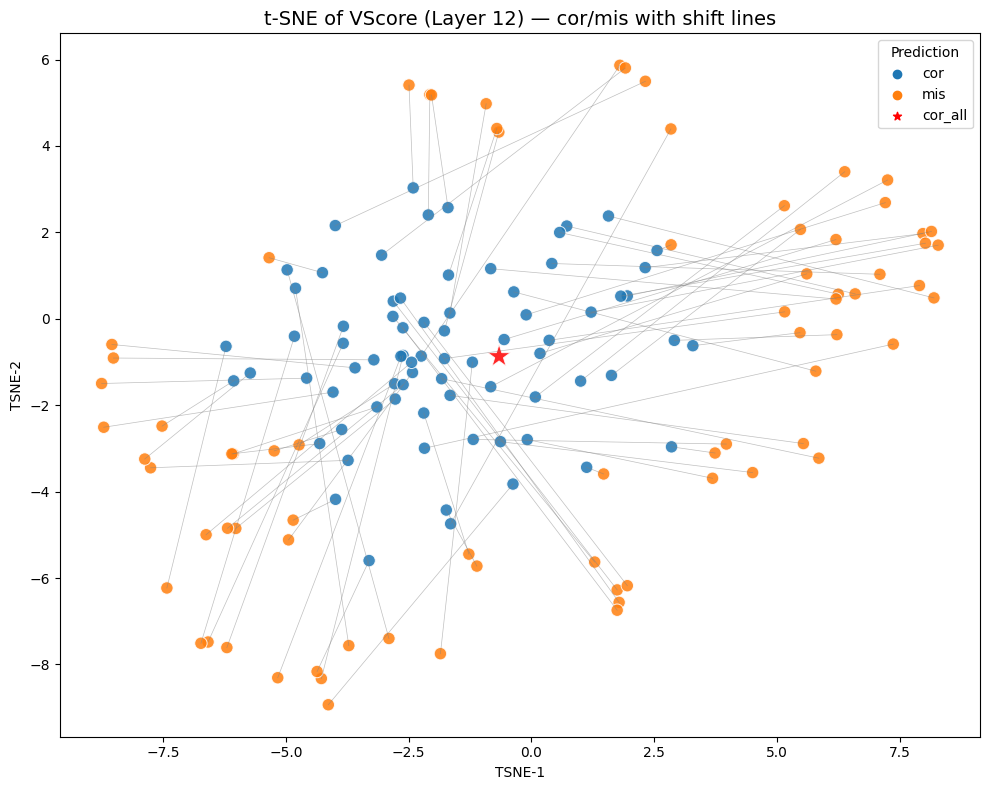

In [11]:
df = plot_tsne_cor_mis_vscores(vscore_dir, id2label)


In [12]:
df

,x,y,label_id,cor_mis,label_name
0,-2.243413,-0.863131,0,cor,apple
1,-2.820240,0.054884,2,cor,baby
2,1.569119,2.378779,3,cor,bear
3,0.719806,2.146166,4,cor,beaver
4,-3.831800,-0.566982,5,cor,bed
...,...,...,...,...,...
146,-0.704182,4.403613,95,mis,whale
147,-6.099051,-3.126137,96,mis,willow_tree
148,5.478199,2.068419,97,mis,wolf
149,1.952752,-6.177226,98,mis,woman


# まとめ
subsamplingしても1-3と傾向が変わらなかったのは嬉しい．
サンプル数の差だけが原因でないことが言える．
また，corからのサンプル方法により結果は変わるかもね.

# ラベルごとにcor/misのVscoreの違いを検定

In [13]:
import os
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

def cliffs_delta(x, y):
    """Calculate Cliff's Delta effect size between two paired samples."""
    n = len(x)
    greater = np.sum(x > y)
    less = np.sum(x < y)
    return (greater - less) / n

def run_labelwise_vscore_tests(vscore_dir, end_li=12, num_labels=100, abs=True, covavg=False, split="repair"):
    results = []
    prefix = ("vscore_abs" if abs else "vscore") + ("_covavg" if covavg else "")

    for label_id in range(num_labels):
        cor_name = f"{prefix}_l1tol{end_li}_label_{label_id}_ori_{split}_cor.npy"
        mis_name = f"{prefix}_l1tol{end_li}_label_{label_id}_ori_{split}_mis.npy"
        cor_path = os.path.join(vscore_dir, cor_name)
        mis_path = os.path.join(vscore_dir, mis_name)

        if not (os.path.exists(cor_path) and os.path.exists(mis_path)):
            continue

        v_cor = np.load(cor_path)[-1]  # shape: (3072,)
        v_mis = np.load(mis_path)[-1]

        if np.any(np.isnan(v_cor)) or np.any(np.isnan(v_mis)):
            continue

        try:
            stat, pval = wilcoxon(v_cor, v_mis)
            mean_shift = np.linalg.norm(v_cor - v_mis)
            delta = cliffs_delta(v_cor, v_mis)
            results.append({
                "label_id": label_id,
                "mean_shift": mean_shift,
                "p_value": pval,
                "cliffs_delta": delta
            })
        except ValueError:
            continue  # raised if input arrays are too small or identical

    if not results:
        print("[Warning] No valid label results.")
        return []

    # FDR補正
    pvals = [r["p_value"] for r in results]
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")

    for r, pcorr, rej in zip(results, pvals_corrected, reject):
        r["p_corrected"] = pcorr
        r["reject_null"] = rej

    # ソートして返す（補正後p値昇順）
    results = sorted(results, key=lambda x: x["p_corrected"])

    print("\n========== Label-wise VScore Shift Tests (FDR-corrected) ==========")
    for r in results:
        mark = "*" if r["reject_null"] else " "
        print(f"Label {r['label_id']:3d} | Shift = {r['mean_shift']:8.4f} | p = {r['p_value']:.2e} | q = {r['p_corrected']:.2e} | delta = {r['cliffs_delta']:.3f} {mark}")
    print("===================================================================")

    return results

In [14]:
vscore_dir = os.path.join(getattr(ViTExperiment, ds).OUTPUT_DIR.format(k=k), "vscores_subsampled")
results = run_labelwise_vscore_tests(vscore_dir)


========== Label-wise VScore Shift Tests (FDR-corrected) ==========
Label   0 | Shift = 8463.8342 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.628 *
Label   4 | Shift = 7083.5109 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.699 *
Label  14 | Shift = 13981.0808 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.649 *
Label  15 | Shift = 16123.2982 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.724 *
Label  16 | Shift = 9704.2527 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.796 *
Label  18 | Shift = 11874.2216 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.829 *
Label  38 | Shift = 14586.4632 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.704 *
Label  50 | Shift = 8727.7767 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.766 *
Label  51 | Shift = 12700.4869 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.684 *
Label  55 | Shift = 6497.7084 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.715 *
Label  65 | Shift = 10697.5271 | p = 0.00e+00 | q = 0.00e+00 | delta = -0.668 *
Label  72 | Shift = 6252.9967 | p = 0.00e+00 | q = 0.00e

# 特定ラベルにおけるVcorとVmisのプロット

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

def plot_vcor_vmis(vscore_dir, tgt_label, title_suffix=""):
    # 1. load vscores
    v_cor, labels_cor = load_vscores_for_similarity(vscore_dir, "cor")
    v_mis, labels_mis = load_vscores_for_similarity(vscore_dir, "mis")

    cor_dict = {lid: v for lid, v in zip(labels_cor, v_cor)}
    mis_dict = {lid: v for lid, v in zip(labels_mis, v_mis)}

    vscore_cor = cor_dict[tgt_label]
    vscore_mis = mis_dict[tgt_label]
    assert vscore_cor.shape == vscore_mis.shape, "Shape mismatch between cor and mis vscores"
    
    x = np.arange(len(vscore_cor))
    
    plt.figure(figsize=(12, 4))
    # plt.plot(x, vscore_cor, label="Vscore (cor)", color="tab:blue", alpha=0.5)
    # plt.plot(x, vscore_mis, label="Vscore (mis)", color="tab:orange", alpha=0.5)
    plt.plot(x, vscore_cor - vscore_mis, label="Vcor - Vmis", color="tab:red", alpha=0.5)

    plt.title(f"Vscore for Label {tgt_label} {title_suffix}", fontsize=14)

    plt.xlabel("Neuron Index", fontsize=12)
    plt.ylabel("Vscore Value", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

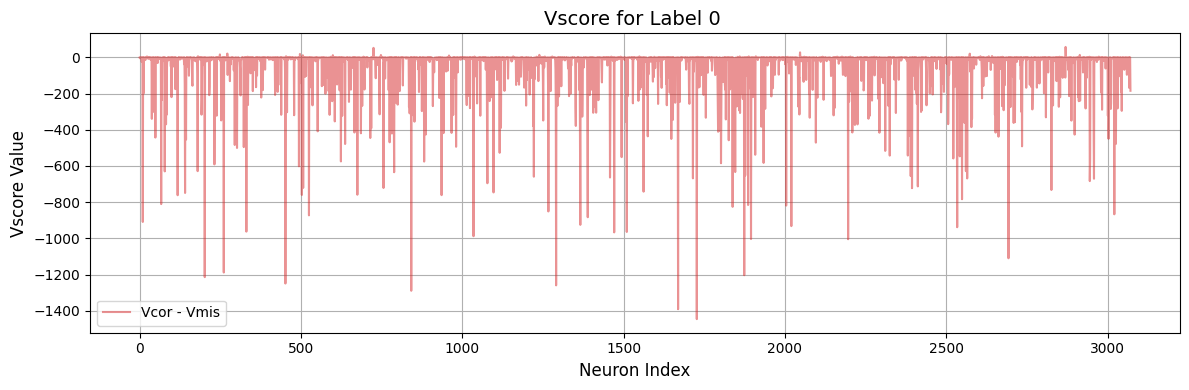

In [16]:
plot_vcor_vmis(vscore_dir, tgt_label=0)

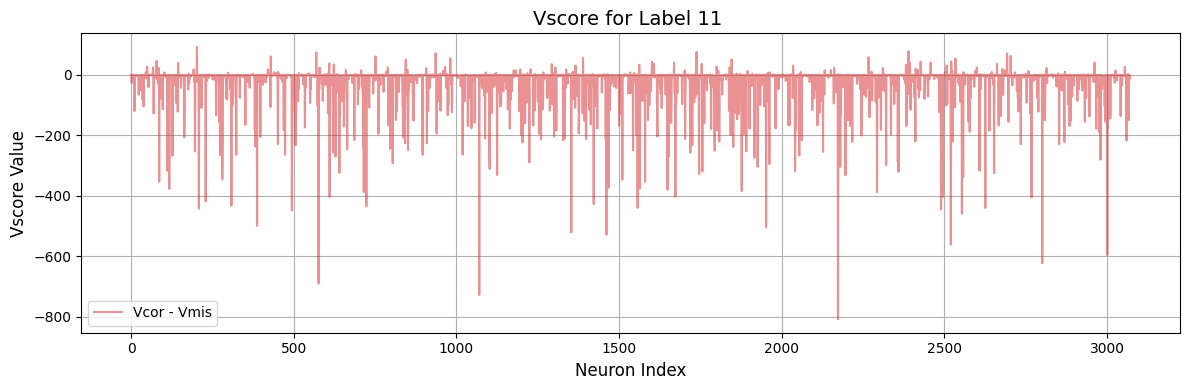

In [17]:
plot_vcor_vmis(vscore_dir, tgt_label=11)

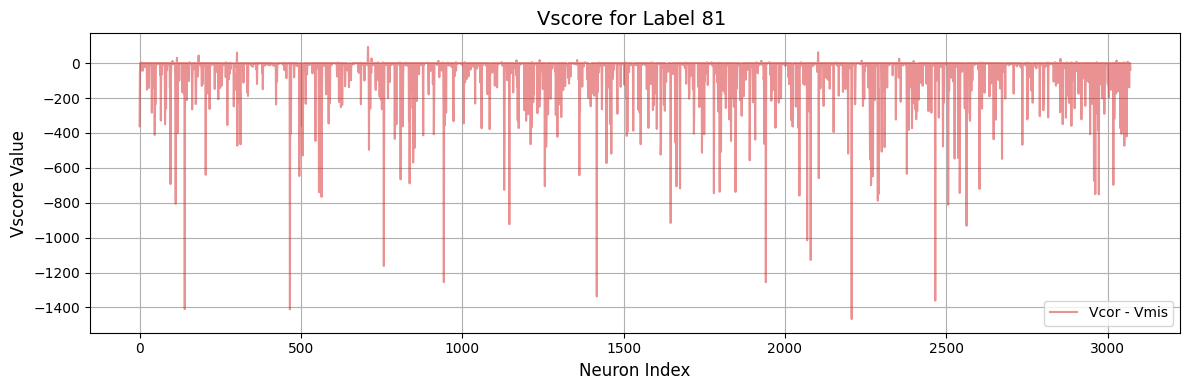

In [18]:
plot_vcor_vmis(vscore_dir, tgt_label=81)